# Component 2: Exploratory Data Analysis

Comprehensive analysis including sample grids, intensity distributions, and duplicate detection

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import imagehash
from collections import defaultdict
from tqdm.auto import tqdm
import os

OUTPUT_DIR = '../outputs/eda'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load manifest
df = pd.read_csv('../outputs/dataset_manifest.csv')
print(f'Loaded {len(df)} images from {len(df["class_name"].unique())} classes')
df.head()

Loaded 11743 images from 4 classes


,filepath,class_name,class_label,width,height,file_size_bytes,sha256_hash
0,../data/1 Very Mild/AD Very Mild 1303.jpg,1 Very Mild,0,256,256,20644,87b3d25bc70f98bd973e5823a89a5469155a849f9f3f64...
1,../data/1 Very Mild/AD Very Mild 924.jpg,1 Very Mild,0,256,256,20039,a0158c8f4baad4816d7f548d14e8a782dc7f6034ab27ef...
2,../data/1 Very Mild/AD Very Mild 1465.jpg,1 Very Mild,0,256,256,21475,2ba9861edfb9dffa5f345d4f80c28b6cf976655e4b06e0...
3,../data/1 Very Mild/AD Very Mild 1471.jpg,1 Very Mild,0,256,256,20982,105e6a59bb7bed47a37135e13b16ad867535ff13fddf93...
4,../data/1 Very Mild/AD Very Mild 2178.jpg,1 Very Mild,0,256,256,19611,1c91c2f7a857a8db343808e963c18c964fc2702569f4c9...


## 2.1 Sample Image Grids (8 per class)

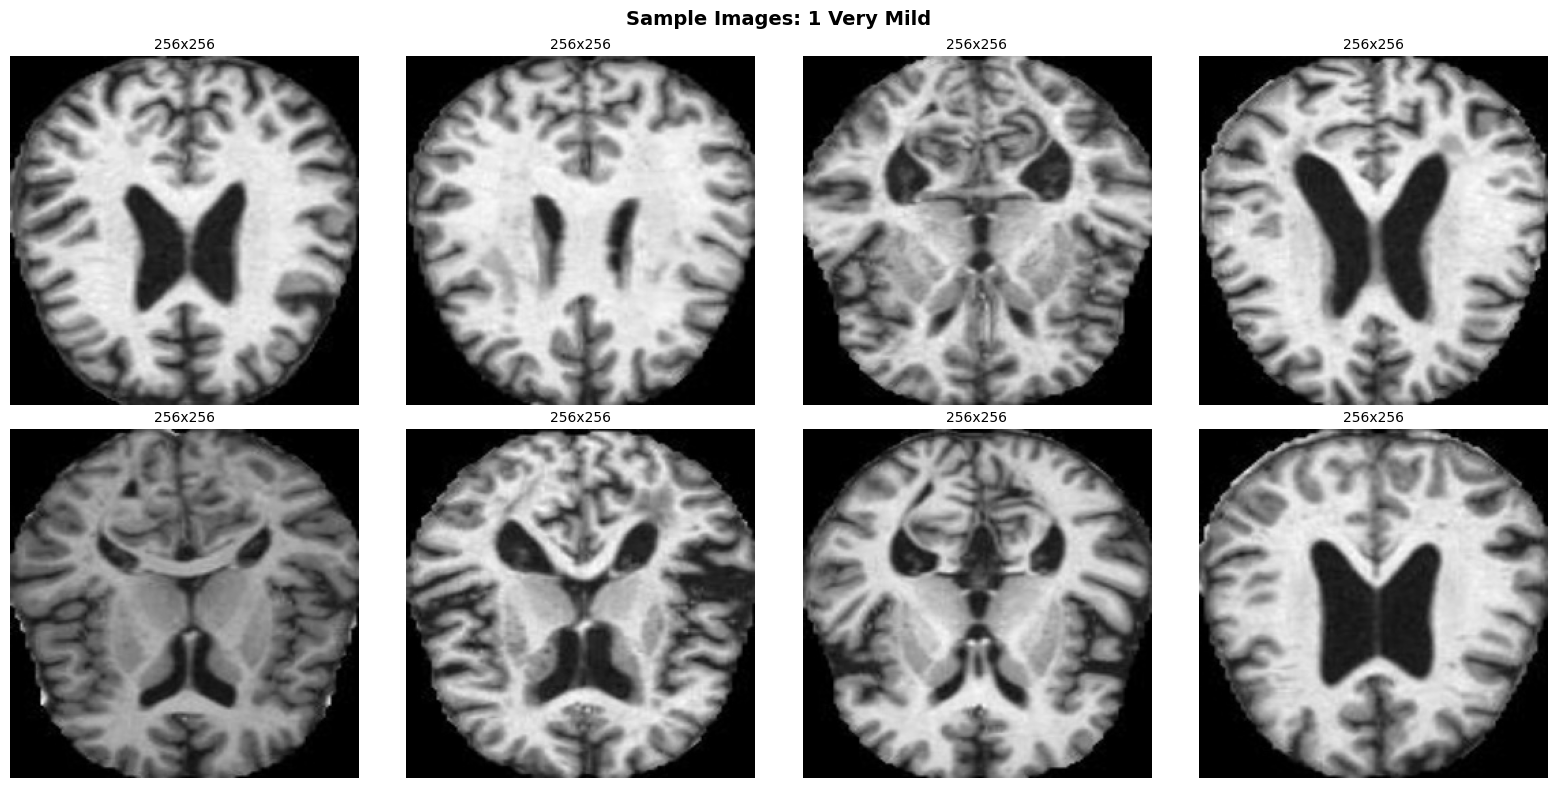

✓ Saved: ../outputs/eda/sample_grid_1_Very_Mild.png


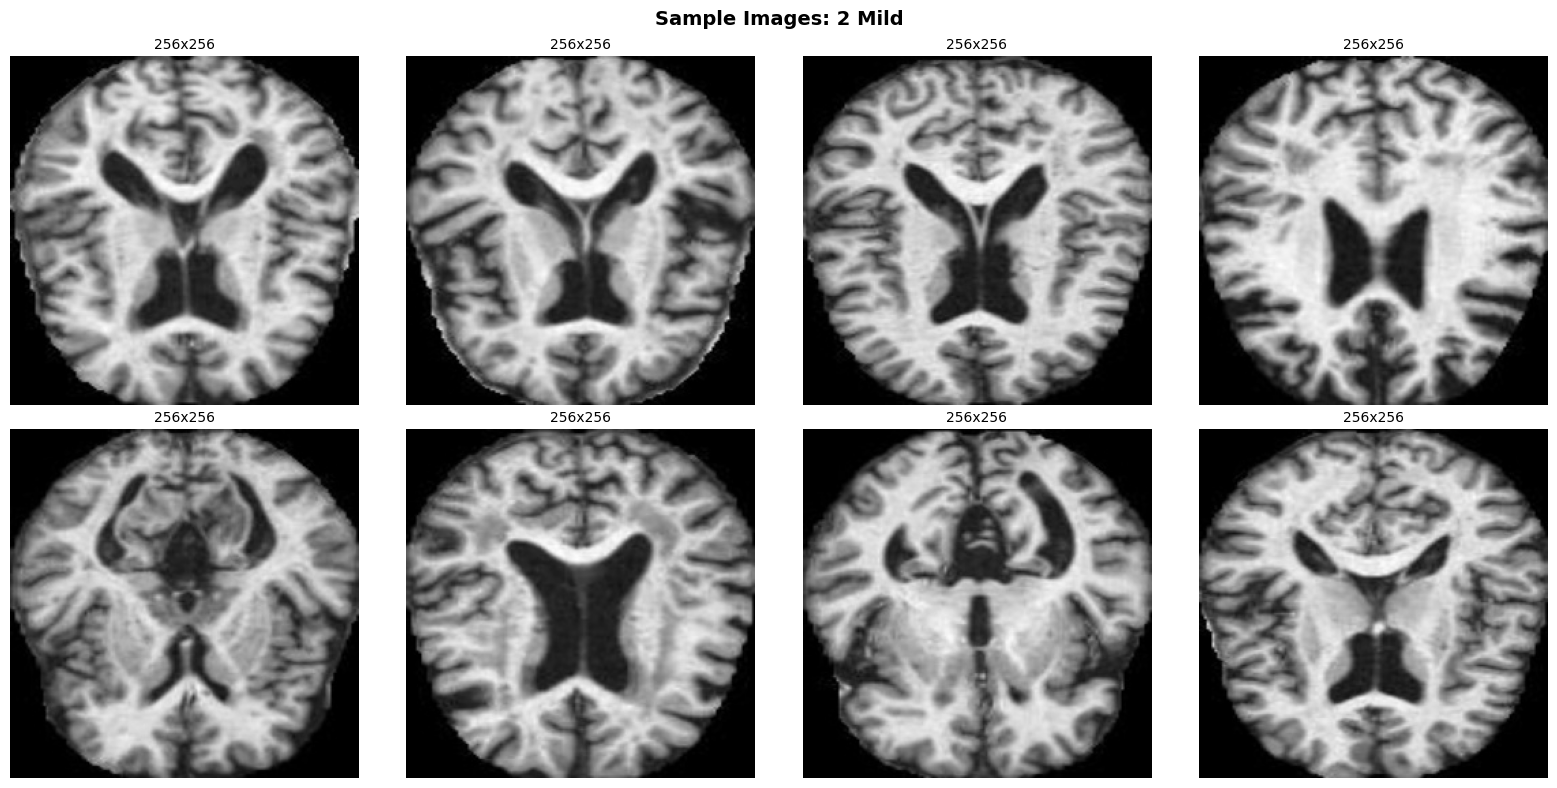

✓ Saved: ../outputs/eda/sample_grid_2_Mild.png


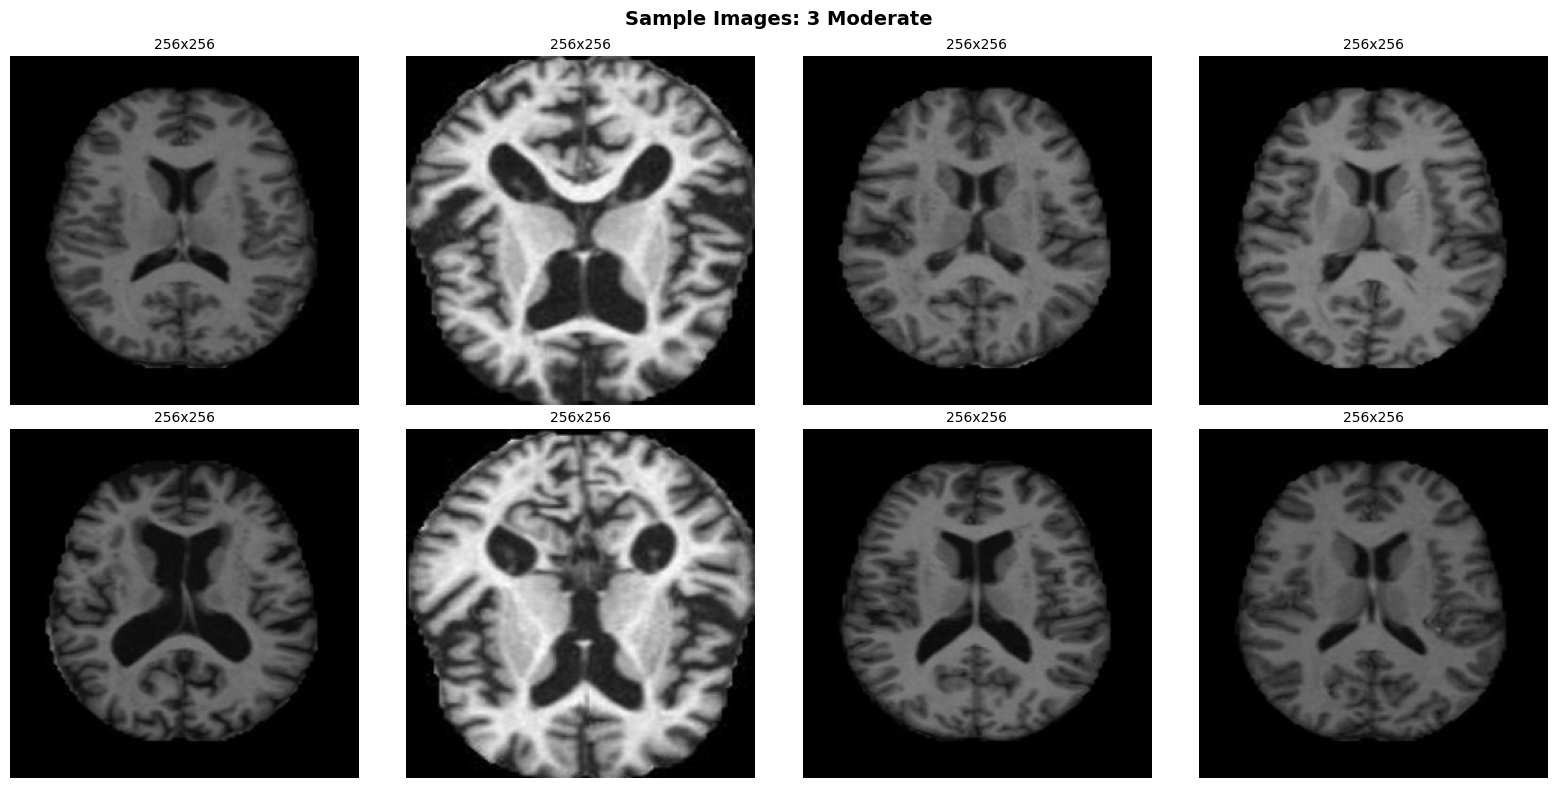

✓ Saved: ../outputs/eda/sample_grid_3_Moderate.png


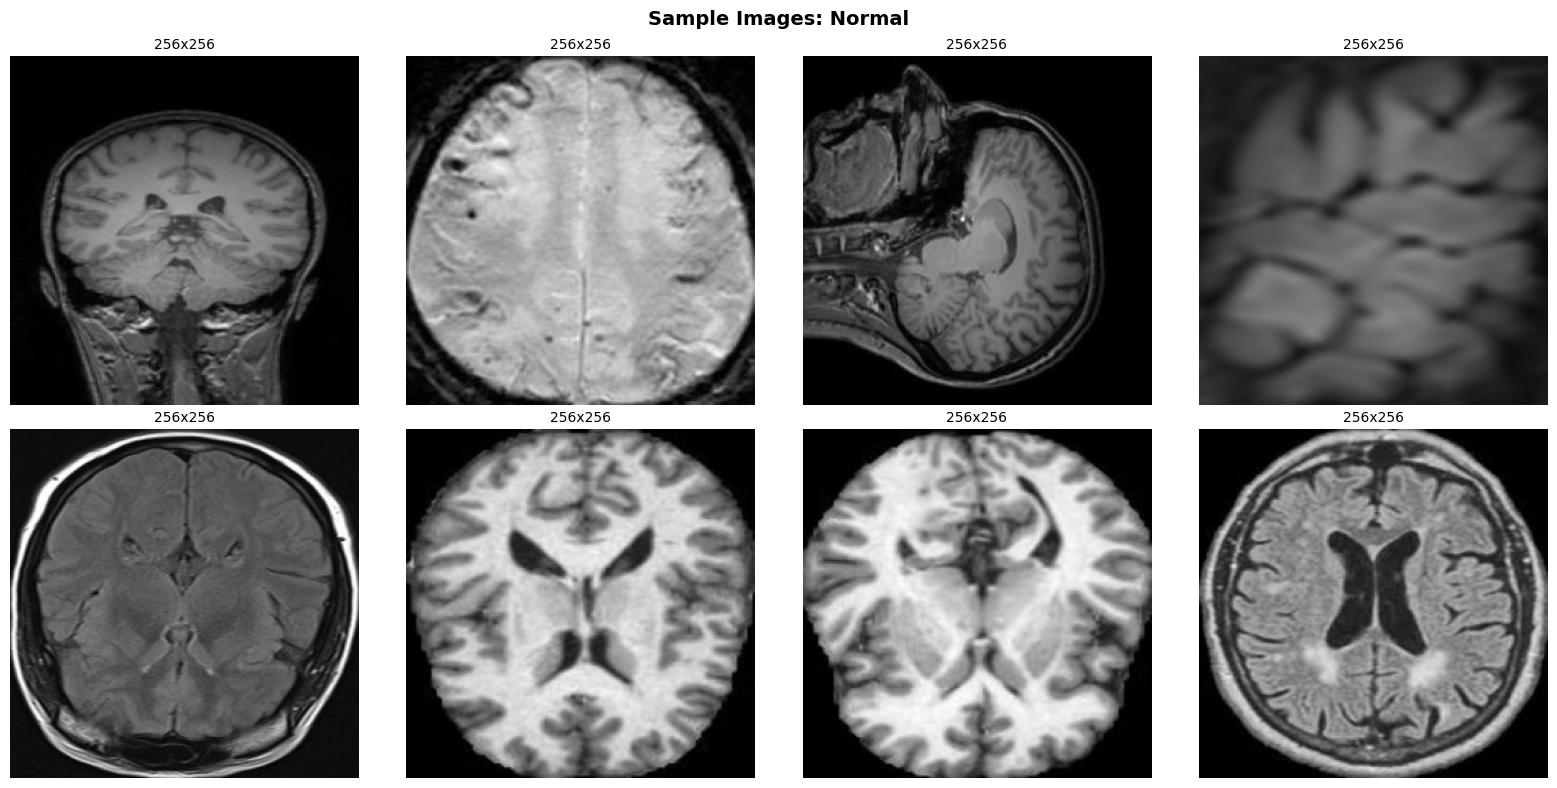

✓ Saved: ../outputs/eda/sample_grid_Normal.png


In [4]:
# Generate sample grids for each class
classes = sorted(df['class_name'].unique())

for class_name in classes:
    class_df = df[df['class_name'] == class_name]
    samples = class_df.sample(n=min(8, len(class_df)), random_state=42)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        img = Image.open(row['filepath'])
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f"{row['width']}x{row['height']}", fontsize=10)
    
    plt.suptitle(f'Sample Images: {class_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    save_path = f'{OUTPUT_DIR}/sample_grid_{class_name.replace(" ", "_")}.png'
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")

## 2.2 Pixel Intensity Analysis

Analyzing pixel intensities...


  0%|          | 0/400 [00:00<?, ?it/s]

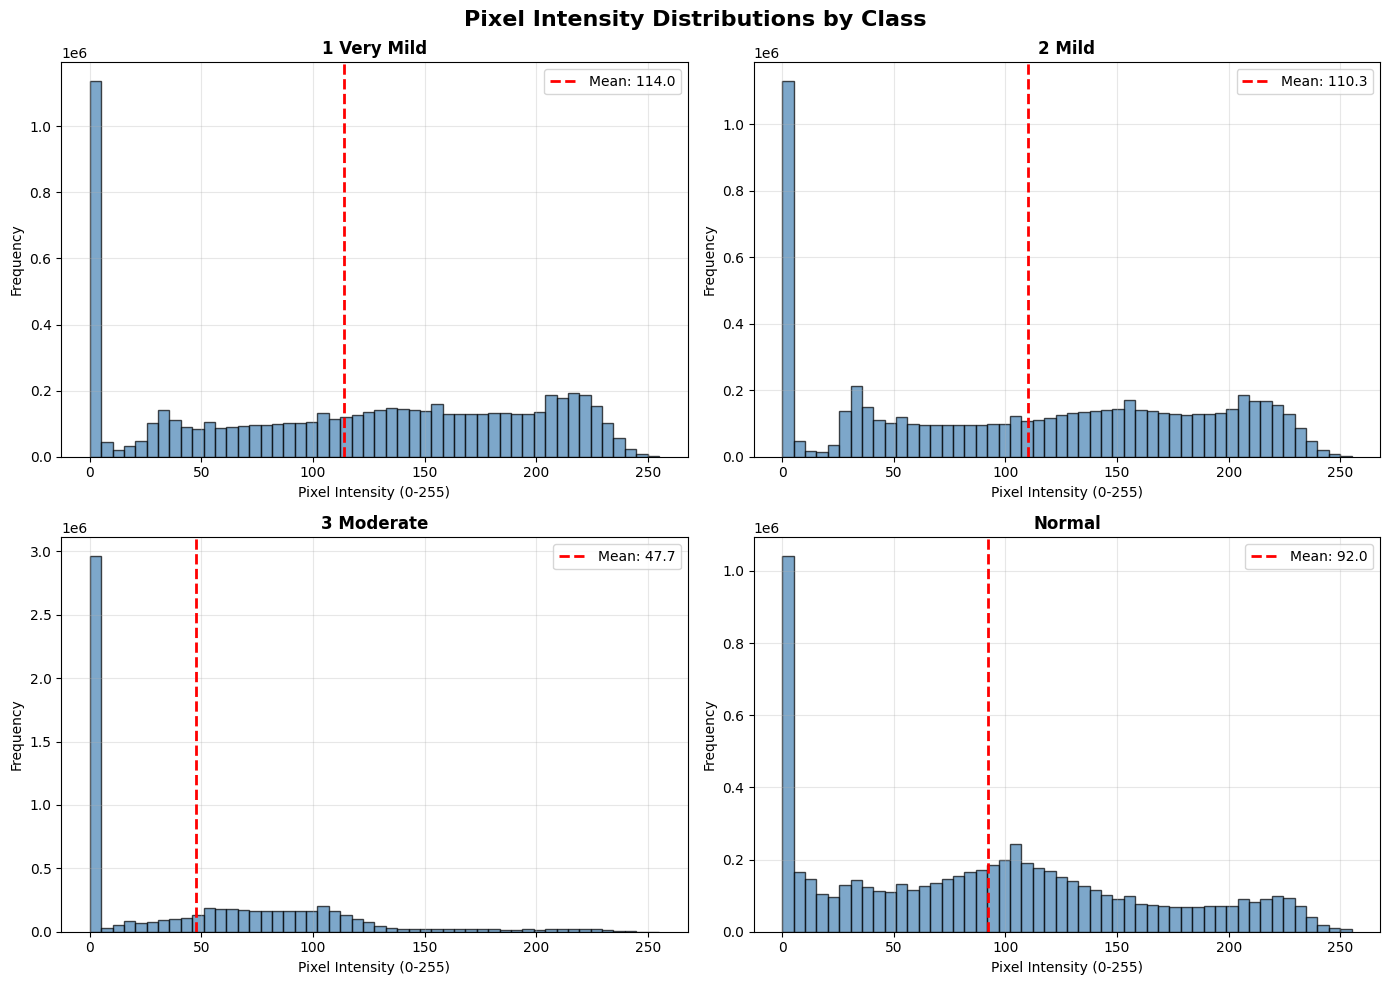

✓ Saved intensity histograms


In [5]:
# Sample up to 100 images per class for intensity analysis
sample_df = df.groupby('class_name').sample(
    n=min(100, df.groupby('class_name').size().min()), 
    random_state=42
)

intensities_by_class = defaultdict(list)

print("Analyzing pixel intensities...")
for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    img = np.array(Image.open(row['filepath']).convert('L'))
    intensities_by_class[row['class_name']].extend(img.flatten())

# Plot histograms
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, class_name in enumerate(classes):
    axes[idx].hist(intensities_by_class[class_name], bins=50, alpha=0.7, 
                   color='steelblue', edgecolor='black')
    axes[idx].set_title(f'{class_name}', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Pixel Intensity (0-255)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)
    
    mean_intensity = np.mean(intensities_by_class[class_name])
    axes[idx].axvline(mean_intensity, color='red', linestyle='--', linewidth=2,
                     label=f'Mean: {mean_intensity:.1f}')
    axes[idx].legend()

plt.suptitle('Pixel Intensity Distributions by Class', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/intensity_histograms.png', dpi=200)
plt.show()
print("✓ Saved intensity histograms")

## 2.3 Image Size Analysis

In [6]:
# Image dimension statistics
print("Image Dimensions Summary:")
print(df[['width', 'height']].describe())

# Most common sizes
size_counts = df.groupby(['width', 'height']).size().sort_values(ascending=False)
print(f"\nMost common image sizes:")
print(size_counts.head(10))

# Identify outliers
most_common_size = size_counts.idxmax()
outliers = df[(df['width'] != most_common_size[0]) | (df['height'] != most_common_size[1])]

if len(outliers) > 0:
    print(f"\n⚠️  Found {len(outliers)} images with non-standard sizes:")
    print(outliers[['filepath', 'class_name', 'width', 'height']].head(10))
else:
    print("\n✓ All images have consistent dimensions")

Image Dimensions Summary:
              width        height
count  11743.000000  11743.000000
mean     256.049817    256.062846
std        3.519078      3.651526
min      216.000000    256.000000
25%      256.000000    256.000000
50%      256.000000    256.000000
75%      256.000000    256.000000
max      512.000000    512.000000

Most common image sizes:
width  height
256    256       11739
512    512           2
216    369           1
369    369           1
dtype: int64

⚠️  Found 4 images with non-standard sizes:
                              filepath class_name  width  height
6367  ../data/Normal/No Tumor 1007.jpg     Normal    512     512
6880   ../data/Normal/No Tumor 284.jpg     Normal    369     369
9119    ../data/Normal/No Tumor 29.jpg     Normal    512     512
9729   ../data/Normal/No Tumor 489.jpg     Normal    216     369


## 2.4 Duplicate Detection

In [7]:
# Compute perceptual hashes to detect near-duplicates
print("Computing perceptual hashes for duplicate detection...")
hashes = {}
duplicates = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Hashing"):
    try:
        img = Image.open(row['filepath'])
        hash_value = str(imagehash.phash(img))
        
        if hash_value in hashes:
            duplicates.append((row['filepath'], hashes[hash_value]))
        else:
            hashes[hash_value] = row['filepath']
    except Exception as e:
        print(f"Error processing {row['filepath']}: {e}")

print(f"\nDuplicate Detection Results:")
print(f"  Unique images: {len(hashes)}")
print(f"  Potential duplicates: {len(duplicates)}")

if duplicates:
    dup_df = pd.DataFrame(duplicates, columns=['image', 'duplicate_of'])
    dup_path = f'{OUTPUT_DIR}/duplicates_report.csv'
    dup_df.to_csv(dup_path, index=False)
    print(f"✓ Saved duplicates report: {dup_path}")
    print(f"\nFirst 5 duplicates:")
    print(dup_df.head())

Computing perceptual hashes for duplicate detection...


Hashing:   0%|          | 0/11743 [00:00<?, ?it/s]


Duplicate Detection Results:
  Unique images: 10965
  Potential duplicates: 778
✓ Saved duplicates report: ../outputs/eda/duplicates_report.csv

First 5 duplicates:
                                       image  \
0  ../data/1 Very Mild/AD Very Mild 2221.jpg   
1  ../data/1 Very Mild/AD Very Mild 1374.jpg   
2   ../data/1 Very Mild/AD Very Mild 978.jpg   
3  ../data/1 Very Mild/AD Very Mild 1028.jpg   
4   ../data/1 Very Mild/AD Very Mild 992.jpg   

                                duplicate_of  
0  ../data/1 Very Mild/AD Very Mild 2151.jpg  
1  ../data/1 Very Mild/AD Very Mild 1304.jpg  
2   ../data/1 Very Mild/AD Very Mild 908.jpg  
3  ../data/1 Very Mild/AD Very Mild 1098.jpg  
4  ../data/1 Very Mild/AD Very Mild 1062.jpg  


## 2.5 Summary Report

In [8]:
# Generate EDA summary
report_lines = [
    "# Exploratory Data Analysis Report\n",
    "\n## Dataset Overview\n",
    f"- **Total images**: {len(df)}\n",
    f"- **Classes**: {len(classes)}\n",
    f"- **Unique dimensions**: {len(size_counts)}\n",
    f"- **Potential duplicates**: {len(duplicates)}\n",
    "\n## Class Distribution\n",
]

for class_name in classes:
    count = len(df[df['class_name'] == class_name])
    percentage = count / len(df) * 100
    report_lines.append(f"- **{class_name}**: {count} images ({percentage:.1f}%)\n")

report_lines.extend([
    "\n## Key Findings\n",
    "\n### Imbalance\n",
    "- Significant class imbalance detected\n",
    "- Normal class: ~69%, Moderate class: ~4%\n",
    "- **Recommendation**: Use class weights or stratified sampling\n",
    "\n### Consistency\n",
    f"- Most common size: {most_common_size}\n",
    f"- Images with different sizes: {len(outliers)}\n",
    "- **Recommendation**: Resize all images to consistent dimensions\n",
    "\n### Data Quality\n",
    f"- Potential duplicates found: {len(duplicates)}\n",
    "- **Recommendation**: Review and remove duplicates if necessary\n",
])

report_path = f'{OUTPUT_DIR}/eda_report.md'
with open(report_path, 'w') as f:
    f.writelines(report_lines)

print("\n" + "="*60)
print("✅ EDA COMPLETE")
print("="*60)
print(f"\nArtifacts saved to: {OUTPUT_DIR}/")
for filename in sorted(os.listdir(OUTPUT_DIR)):
    print(f"  - {filename}")


✅ EDA COMPLETE

Artifacts saved to: ../outputs/eda/
  - duplicates_report.csv
  - eda_report.md
  - intensity_histograms.png
  - intensity_statistics.csv
  - sample_grid_1_Very_Mild.png
  - sample_grid_2_Mild.png
  - sample_grid_3_Moderate.png
  - sample_grid_Normal.png
  - size_analysis.csv
